### Morphing with StyleGan-2-ADA

1. I tried to do morphing between two synthetic images and two real images. I included the results to be shown at https://www.uaembroidery.com/

### Resources used to learn about morphing

1. The youtube video outling the process of image morphing with human faces https://www.youtube.com/watch?v=J2nTo0cYVBk

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [5]:
import os
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
# Modify these to prolong video duration to your liking
EXPERIMENTS = "/content/drive/MyDrive/data/gan/2800_batch_results/"
NETWORK_NAME = "network-snapshot-000400.pkl"
NETWORK = os.path.join(EXPERIMENTS, "00009-training_dataset-auto1-resumecustom/", NETWORK_NAME)
STEPS = 210
FPS = 30
FREEZE_STEPS = 5

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Convert Start image to GAN latent vector.

In [6]:
START = "/content/drive/MyDrive/data/gan/fakes/seed0632.png"
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_start --target={START} --network={NETWORK}"
!{cmd}

Loading networks from "/content/drive/MyDrive/data/gan/2800_batch_results/00009-training_dataset-auto1-resumecustom/network-snapshot-000400.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.52 loss 24564.88
step    2/1000: dist 0.50 loss 27638.19
step    3/1000: dist 0.52 loss 27166.07
step    4/1000: dist 0.52 loss 26250.07
step    5/1000: dist 0.50 loss 24952.62
step    6/1000: dist 0.33 loss 23350.03
step    7/1000: dist 0.55 loss 21507.70
step    8/1000: dist 0.34 loss 19483.09
step    9/1000: dist 0.49 loss 17339.01
step   10/1000: dist 0.32 lo

# Convert End Image to GAN latent vector

In [7]:
END = "/content/drive/MyDrive/data/gan/fakes/seed0612.png"
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_end --target={END} --network={NETWORK}"
!{cmd}

Loading networks from "/content/drive/MyDrive/data/gan/2800_batch_results/00009-training_dataset-auto1-resumecustom/network-snapshot-000400.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %106 : int = prim::profile_ivalue(%104)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.23 loss 24564.59
step    2/1000: dist 0.40 loss 27638.08
step    3/1000: dist 0.46 loss 27166.02
step    4/1000: dist 0.35 loss 26249.91
step    5/1000: dist 0.24 loss 24952.36
step    6/1000: dist 0.31 loss 23350.00
step    7/1000: dist 0.58 loss 21507.72
step    8/1000: dist 0.36 loss 19483.10
step    9/1000: dist 0.56 loss 17339.07
step   10/1000: dist 0.34 lo

# Check reconstructed images from GAN Latent Vectors

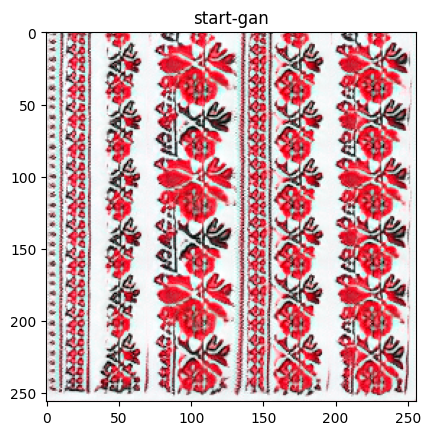

In [10]:
import cv2 
import matplotlib.pyplot as plt
img_gan_source = cv2.imread('/content/out_start/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('start-gan')
plt.show()

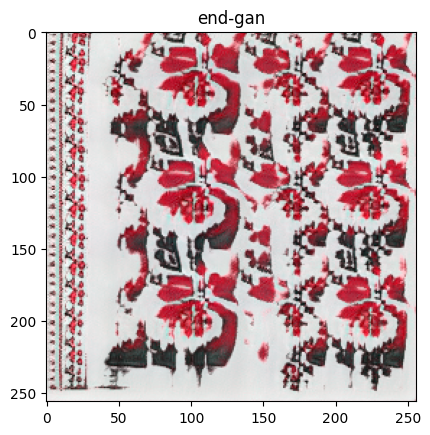

In [11]:
img_gan_target = cv2.imread('/content/out_end/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('end-gan')
plt.show()

# Generating Video

I used following resource to create a transition video: https://www.youtube.com/watch?v=J2nTo0cYVBk

In [13]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

VIDEO_NAME = "morphing.mp4"
!pip install imageio-ffmpeg
lvec1 = np.load('/content/out_start/projected_w.npz')['w']
lvec2 = np.load('/content/out_end/projected_w.npz')['w']

network_pkl = NETWORK
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer(f'/content/{VIDEO_NAME}', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/150 [00:00<?, ?it/s]

# Downloading Video

In [14]:
from google.colab import files
files.download(VIDEO_NAME) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>